# Bitcoin price forecast using time series modeling

In [6]:
import pandas as pd
import numpy as np
import siuba as siu
import altair as alt
from time import strftime

In [7]:
data = pd.read_csv('bitcoin.csv', parse_dates=True).drop(['price_close','price_open', 'volume_traded', 'trades_count','time_period_end', 'time_open', 'time_close'], axis=1)

In [10]:
data["time_period"] = pd.to_datetime(data['time_period_start'])
data["price_time"] = data["time_period"].dt.strftime('%H:%M:%S')
data.head()

,time_period_start,price_high,price_low,time_period,price_time
0,2020-01-01T00:00:00.0000000Z,7165.72,7165.71,2020-01-01 00:00:00+00:00,00:00:00
1,2020-01-01T00:00:01.0000000Z,7168.30,7168.30,2020-01-01 00:00:01+00:00,00:00:01
2,2020-01-01T00:00:02.0000000Z,7170.50,7170.50,2020-01-01 00:00:02+00:00,00:00:02
3,2020-01-01T00:00:04.0000000Z,7169.20,7169.20,2020-01-01 00:00:04+00:00,00:00:04
4,2020-01-01T00:00:05.0000000Z,7169.20,7169.20,2020-01-01 00:00:05+00:00,00:00:05


In [11]:
dataset = pd.DataFrame(data, columns = ['time_period', 'price_high', 'price_low'])
dataset.head()

,time_period,price_high,price_low
0,2020-01-01 00:00:00+00:00,7165.72,7165.71
1,2020-01-01 00:00:01+00:00,7168.30,7168.30
2,2020-01-01 00:00:02+00:00,7170.50,7170.50
3,2020-01-01 00:00:04+00:00,7169.20,7169.20
4,2020-01-01 00:00:05+00:00,7169.20,7169.20


In [12]:
#identify minute, hour, and daily levels of price
dataset["minute"] = dataset["time_period"].dt.second == 0
dataset["hour"] = (dataset["time_period"].dt.minute == 0) & (dataset["minute"] == True)


In [13]:
#check that it's actually identifying the correct values
minute = dataset[dataset["minute"]==True]

In [14]:
hour = dataset[dataset["hour"]==True]
hour

,time_period,price_high,price_low,minute,hour
0,2020-01-01 00:00:00+00:00,7165.72,7165.71,True,True
5573,2020-01-01 04:00:00+00:00,7196.99,7196.98,True,True
6628,2020-01-01 05:00:00+00:00,7186.40,7183.85,True,True
7797,2020-01-01 06:00:00+00:00,7197.31,7197.31,True,True
8995,2020-01-01 07:00:00+00:00,7201.30,7201.30,True,True
9881,2020-01-01 08:00:00+00:00,7185.90,7185.90,True,True


### data includes 192 minutes of data, 8 hours, <1 day, 10,000 seconds

If the data goes from midnight to 8am, there would be 28,800 seconds of data. This dataset has 10,000 seconds, so over half of the length of time is missing. 

In [15]:
alt.Chart(minute).mark_line().encode(
    x='time_period',
    y='price_high:Q',)

alt.Chart(...)

In [62]:
dataset.set_index('time_period', inplace=True)

### Subset data
Hour 6 starts at row 7797, so we're going to stop at 7796

In [65]:
train = dataset[:7797]
test = dataset[7797:]

## Forecasting with ARIMA

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [18]:
timeseries = train["price_high"]

## Time series decomposition

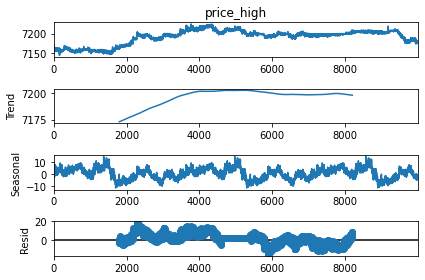

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(dataset['price_high'], model='additive', period=3600).plot()

In [44]:
dftest = adfuller(dataset['price_high'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.489714
p-value                           0.538593
#Lags Used                       13.000000
Number of Observations Used    9986.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64

Using dickey-fuller test, p-value does not meet standards for stationarity (p < 0.05).  Based on trend plot above, there seems to be an upwards trend, so we take first differences.

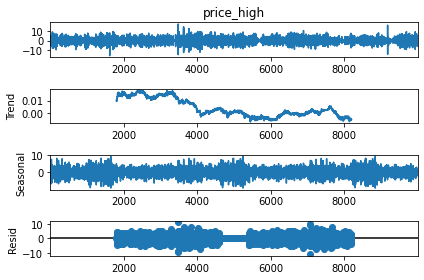

In [47]:
diff_1 = dataset['price_high'].diff(1)
diff_1.dropna(inplace=True)
fig = seasonal_decompose(diff_1, model='additive', period=3600).plot()

In [48]:
dftest = adfuller(diff_1, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -37.687444
p-value                           0.000000
#Lags Used                       12.000000
Number of Observations Used    9986.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64

DF value seems to be acceptible, but trend is now reversed and all components appear to have more noise. 

#### Determine p,d,q 

p = # autoregressive terms

d = # nonseasonal differences needed for stationarity

q = # lagged forecast errors in prediction equation

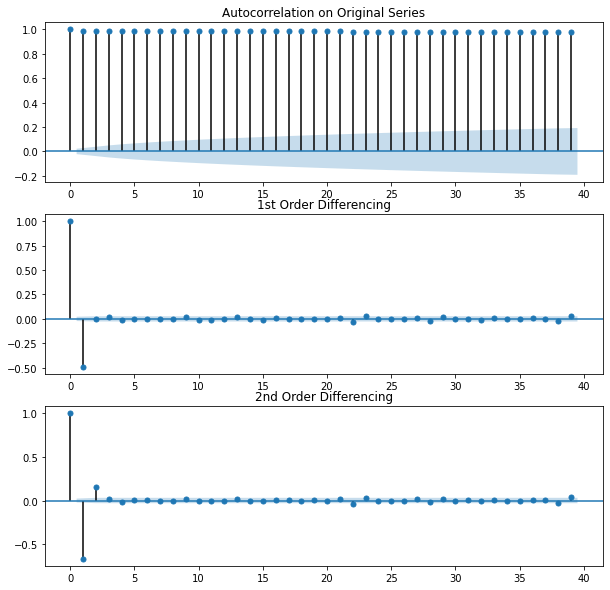

In [20]:
# determine order of differencing w/auto correlation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
              title="Autocorrelation on Original Series")
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2,
              title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3,
              title="2nd Order Differencing")

It looks like the third lag is below the significance level, so I'm going to use d=2

#### Next, find the p value (# of autoregressive terms)

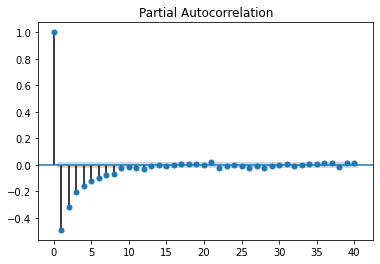

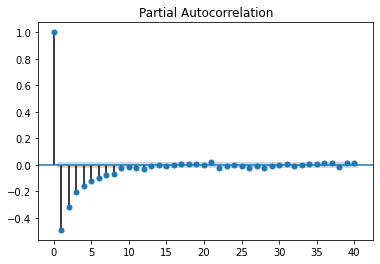

In [21]:
plot_pacf(timeseries.diff().dropna(), lags=40)

Honestly, it looks like the first 6 are above the significance level, so let's go with p = 6

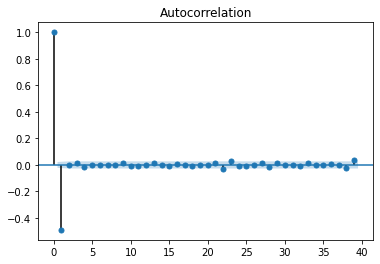

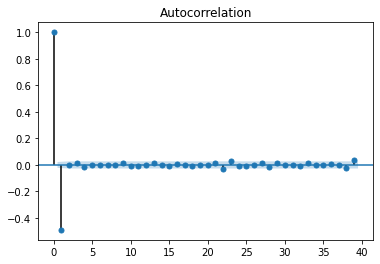

In [22]:
plot_acf(timeseries.diff().dropna())

I know this looks like 2, but I messed around with the ARIMA a bit and it was predicting better with 3.

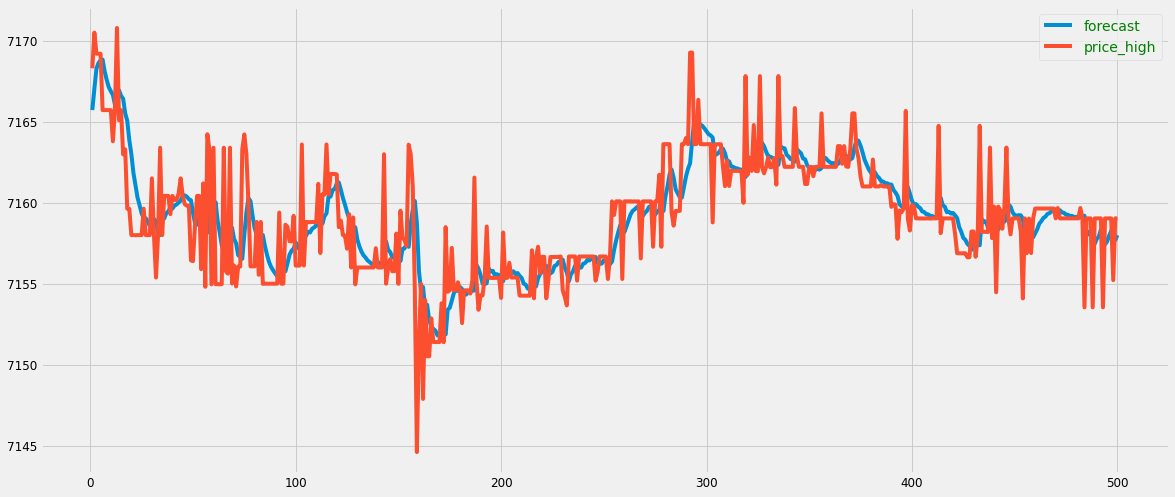

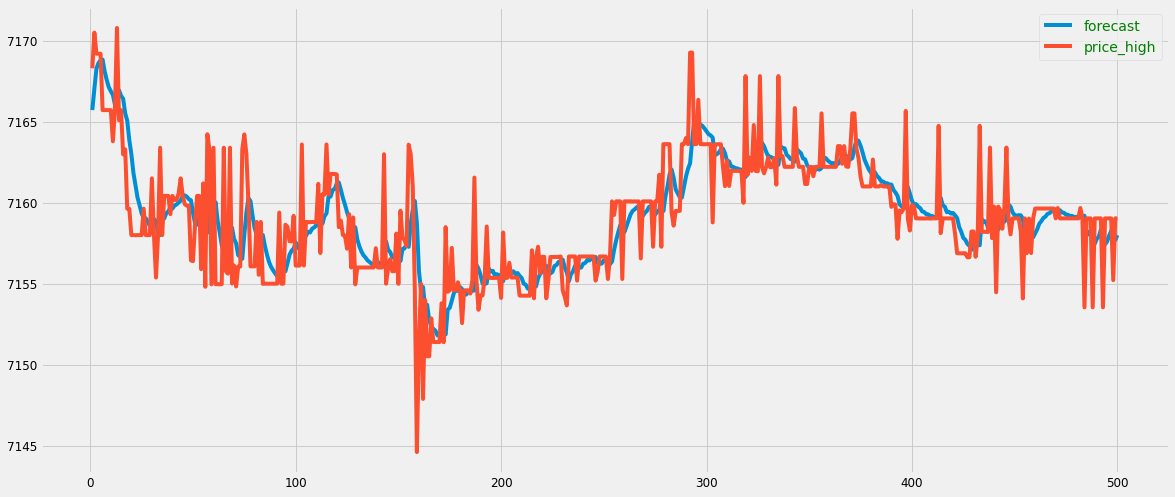

In [118]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(timeseries, order=(6,1,3))
arima_results = model.fit()
arima_results.plot_predict(1, 500)

### What would the ARIMA model predict for the next value (which would be the start of the test data)?

In [135]:
print(f"Predicted price for 7:00 AM: {results.forecast(steps=1)[0]}")
print(f"Actual price for 7:00 AM: 7197.31")

Predicted price for 7:00 AM: [7197.60856771]
Actual price for 7:00 AM: 7197.31


#### Honestly, that's really not that bad. One minute into the future, the ARIMA model works.  If you just look **one minute** into the future.  

## SARIMA forecasting model
### A Failure, here for all to see

 Because I need to make sure that I'm not using the best of the best.

In [78]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

Make a shiny new dataset.

In [87]:
price = dataset.drop(columns=['price_low', 'minute', 'hour'])
price.head()

,price_high
time_period,
2020-01-01 00:00:00+00:00,7165.72
2020-01-01 00:00:01+00:00,7168.30
2020-01-01 00:00:02+00:00,7170.50
2020-01-01 00:00:04+00:00,7169.20
2020-01-01 00:00:05+00:00,7169.20


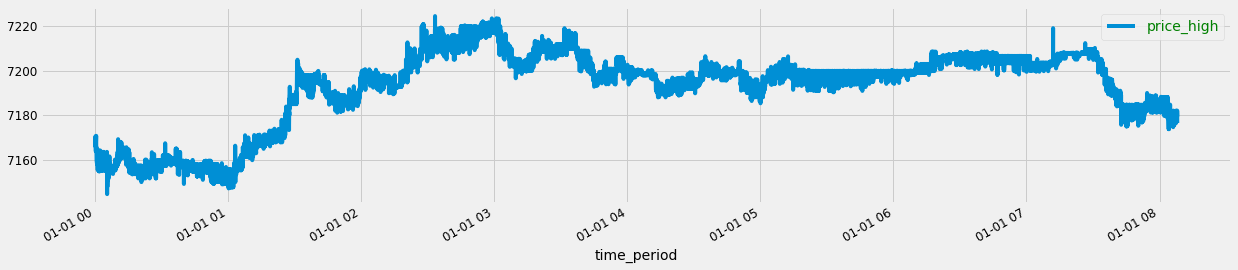

In [88]:
price.plot(figsize=(19,4))
plt.show()

The price goes up 120 points between midnight and 2am, then appears to drop a little between 7 and 8 am.  

In [136]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Let's use a for loop to find the best parameters for the SARIMA, which not only uses the p,d,q parameters from the ARIMA but also 
This takes a while, so if you don't want to run it I totally understand.

In [91]:
#find best model parameters (p,d,q)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(price,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:205971.65149372182
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:198333.27714054688
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:49271.18532183461
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:47554.89080797373
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:49276.84595072758
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:52782.074436479044
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:47837.74098591737
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:47547.055945979926
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:198470.808391426
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:178224.28405499828
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:48875.77529704386
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:46536.46392919543
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:48887.33150897637
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:53482.537276513205
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:47116.233832942045
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:46532.85232907387
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:46678.35426315456
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:46627.48179728284
ARIM

The lower the AIC, the better. Unfortunately, none of these are particularly stellar. :\

Looks like `ARIMA(0, 1, 1)x(1, 0, 1, 12)12` is the best we can do here

In [100]:
mod = sm.tsa.statespace.SARIMAX(price,
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7881      0.005   -170.246      0.000      -0.797      -0.779
ar.S.L12       0.5140      0.096      5.363      0.000       0.326       0.702
ma.S.L12      -0.5158      0.096     -5.362      0.000      -0.704      -0.327
sigma2         3.8227      0.031    124.855      0.000       3.763       3.883


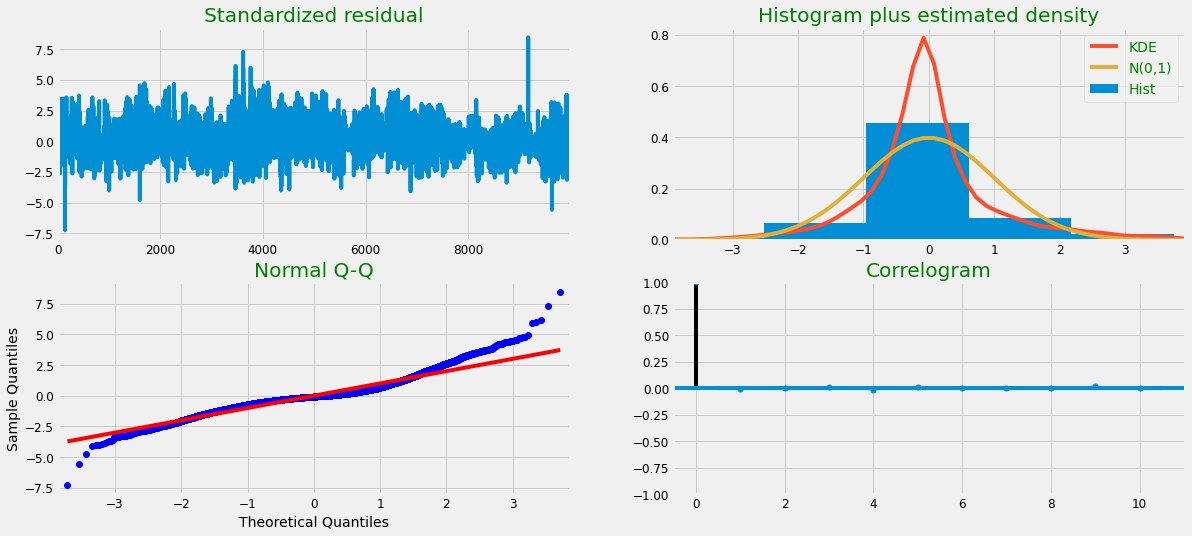

In [96]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

The issue here is I need to figure out why the get_prediction start function isn't letting me input a datetime.  If I had more time I'd probably fiddle with it and figure out why it's not recognizing a field that was manually converted to datetime, or maybe the model is set to return date values rather than hour (which doesn't seem true given the chart output). 

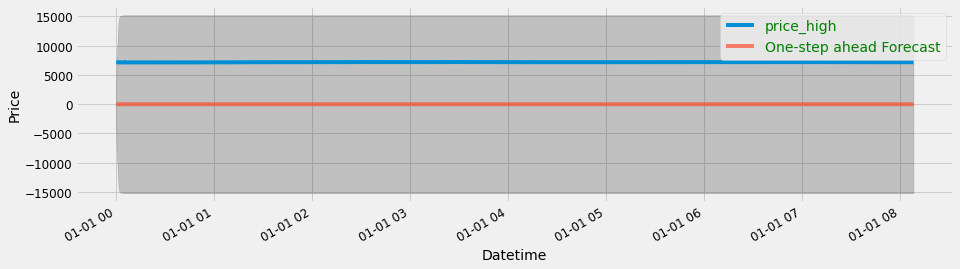

In [104]:

pred = results.get_prediction(start=pd.to_datetime('2020-01-01 00:00:00'), dynamic=True, full_results=True)
pred_ci = pred.conf_int()
ax = price.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Datetime')
ax.set_ylabel('Price')
plt.legend()
plt.show()

### In Which It All Breaks Down
Now I can't see what the MSE is for the model because the index is in this datetime format and I'm a bit stuck figuring out why it's not interpreting it properly (the datetime is in the right format, it's set as the df index, this is the first datetime as a string...) so I'm leaving the failure here because I think the SARIMA may be a better model than the ARIMA but was stuck with a silly datetype issue. 

In [107]:
y_forecasted = pred.predicted_mean
y_truth = price['2020-01-01 00:00:00+00:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2020-01-01 00:00:00+00:00   NaN
2020-01-01 00:00:01+00:00   NaN
2020-01-01 00:00:02+00:00   NaN
2020-01-01 00:00:04+00:00   NaN
2020-01-01 00:00:05+00:00   NaN
                             ..
2020-01-01 08:07:53+00:00   NaN
2020-01-01 08:07:57+00:00   NaN
2020-01-01 08:07:58+00:00   NaN
2020-01-01 08:08:00+00:00   NaN
price_high                  NaN
Length: 10001, dtype: float64
The Root Mean Squared Error is 2020-01-01 00:00:00+00:00   NaN
2020-01-01 00:00:01+00:00   NaN
2020-01-01 00:00:02+00:00   NaN
2020-01-01 00:00:04+00:00   NaN
2020-01-01 00:00:05+00:00   NaN
                             ..
2020-01-01 08:07:53+00:00   NaN
2020-01-01 08:07:57+00:00   NaN
2020-01-01 08:07:58+00:00   NaN
2020-01-01 08:08:00+00:00   NaN
price_high                  NaN
Length: 10001, dtype: float64


### TL;DR

Eight hours of second-grain data isn't enough when you're trying to make seasonal predictions - if you look at the trend graphs in the decomposition, you can see that it is trending upwards but because this is just one morning of data (and it's on a holiday in the winter, after a major spending period) so that trend doesn't mean every morning looks the same. Time series forecasting works best when it has other mornings to compare against, rather than data from the same day. 

That being said, if you're trying to make a short term prediction, ARIMA (surprisingly) works relatively well even with the limited (and somewhat incomplete) dataset. 